# Proyecto: Predicción de Neumonía

### Problema a Resolver: ¿Podemos clasificar correctamente radiografías de pulmones de pacientes que tienen neumonía y de pacientes que tienen pulmones sanos?

## Importamos las librerías necesarias

In [1]:
import random, os
import numpy as np
import torch
import zipfile
from fastai.vision.all import *

In [3]:
with zipfile.ZipFile('../Práctica 2/archive.zip', 'r') as archive:
   # Extrae todo el contenido del achivo ZIP en el directorio actual
   archive.extractall("../Práctica 2/")

In [4]:
os.listdir("../Práctica 2/chest_xray")

['chest_xray', 'test', 'train', 'val', '__MACOSX']

Aquí definimos la ruta base de nuestros datos.

In [5]:
path = Path("../Práctica 2/chest_xray"); path.ls()

(#5) [Path('../Práctica 2/chest_xray/chest_xray'),Path('../Práctica 2/chest_xray/test'),Path('../Práctica 2/chest_xray/train'),Path('../Práctica 2/chest_xray/val'),Path('../Práctica 2/chest_xray/__MACOSX')]

DataLoader es una clase que lo que hará es proveer lotes de unos cuántas imágenes a un tiempo dado.

In [6]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = data.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


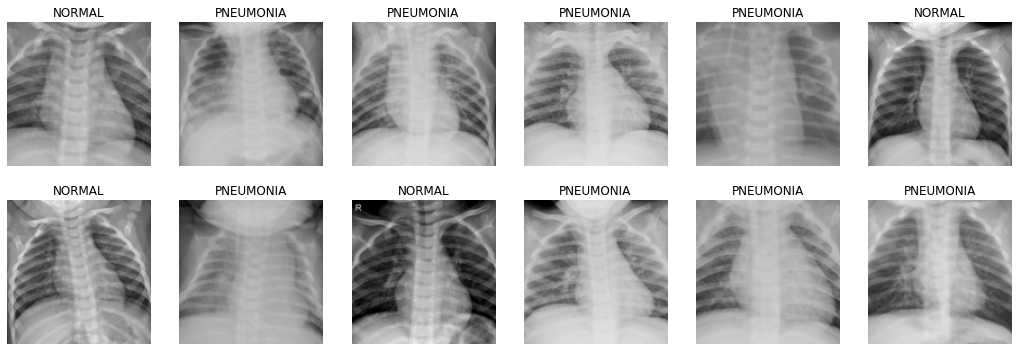

In [7]:
dls.valid.show_batch(max_n=12, nrows=2)

Haremos un pequeño chequeo para comprobar las categorías cin las que estamos trabajando y confirmar que solo tenemos 'Normal' y 'Pneumonia'

In [8]:
print(dls.vocab)

['NORMAL', 'PNEUMONIA']


In [9]:
len(dls.train_ds), len(dls.valid_ds)

(9370, 2342)

## Análisis

A simple vista, podemos asumir que las radiografías que presentan una masa blanca sobre los pulmones podría ser indicios de neuminía. Pero no podemos confirmar que sea esa la razón (a menos que estudiemos años de medicina). Lo mejor es entrenar nuestra red para poder clasificar de manera correcta estas imágenes.

## Creando modelo usando ResNet

(Definir qué es ResNet)

Para trabajar, aprovecharemos que FastAI tiene incluidos preentrenados de ResNet disponibles.

- ResNet18
- ResNet34
- ResNet50
- ResNet101
- ResNet152

La diferencia entre cada uno de los modelos es el tamaño (del número de capas que tiene?) de la red, siendo ResNet152 la más grande y entrenada con mayor cantidad de imágenes.

Para esta pequeña práctica, usaremos **ResNet18**

In [10]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\brugi/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.366145,0.186682,0.064475,0.935525,05:35


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.151180,0.089547,0.029462,0.970538,04:56
1,0.102125,0.061660,0.024338,0.975662,04:52
2,0.059684,0.055256,0.020495,0.979505,04:54
3,0.043662,0.050567,0.017079,0.982921,04:55
4,0.028405,0.032688,0.011102,0.988898,04:57
5,0.018739,0.022985,0.008113,0.991887,04:59


In [17]:
learn.save('model_1')
#learn.load('model_1')

Path('models/model_1.pth')

Como primer entrenamiento rápido los resiltados se ven prometedores. Pero no significa que hayamos terminado. Si, conseguimos una precisión de 99%, pero eso nos hace preguntarnos varias cosas:

- ¿Es esta precisión suficiente mente bena?
- ¿Tenemos que hacer más modelos y entrenarlos de manera diferente?
- ¿Es necesario hacer optimización del modelo?

Todo depende también del contexto en que se este trabajando. En este ejemplo, es un ámbito médico. Por lo que no estaría mal comprobar si podemos realizar un poco más de optimización. El modelo que tenemos actualmente puede ser suficiente para realizar el trabajo. 

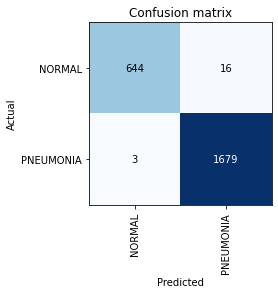

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Entonces podemos ver aquí que el modelo lo hizo muy bien.

El principal problema que tiene el modelo es producir falsos positivos. En este caso 16 pacientes tendrán neumonía cuando en realidad no la tienen. Sin embargo, la métrica más importante en este caso son los falsos negativos, de los cuales hay 3. No es perfecto, pero es un muy buen resultado en general.

Notamos que obtuvimos algunas clasificaciones incorrectas, que podemos verlass explícitamente.

Aquí, elegiré las 3 principales pérdidas

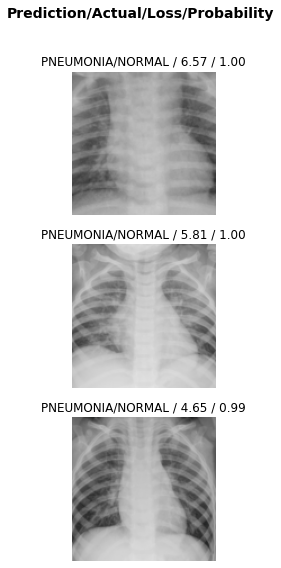

In [32]:
interp.plot_top_losses(3, nrows=3)

Esta puede ser una oportunidad para solucionar problemas en el conjunto de datos. Por ejemplo, si una imagen está etiquetada incorrectamente.

Es curioso que la gran masa blanca en el área del pecho en los clasificados incorrectamente arriba se parezca mucho al lote de prueba que mostramos anteriormente.

## Mejorando el Modelo

Ajustar la tasa de aprendizaje puede ser una mejora. Si nuestra tasa de aprendizaje es demasiado baja, puede llevar una eternidad entrenar nuestro modelo. Además, significa que podríamos sobreajustarnos, porque cada vez que hacemos un pase completo a través de los datos, le damos a nuestro modelo la oportunidad de memorizarlos.

Continuaremos usando ResNet18, por los buenos resultados que obtuvimos.

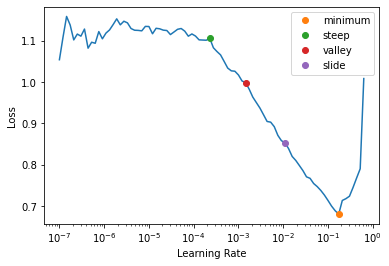

In [15]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [18]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 1.74e-02, steepest point: 2.29e-04


## Interpretando el Learner

La idea es elegir una tasa de aprendizaje que no esté ni muy alto ni muy bajo.

La gráfica que sacamos anteriormente nos puede ayudar a calcular eso.

Idealmente, queremos elegir un punto en el que la Pérdida (Loss) siga disminuyendo, y no haya comenzado a crecer de nuevo. En la gráfica, parece ocurrir cerca del 10^-1.

La disminución de la pérdida comienza alrededor de 10 ^ -4. Elegiré un valor entre 10 ^ -3 y 10 ^ -2.

Hay que tener en cuenta que el Learner está en una escala logarítmica, por lo que el punto medio entre 10 ^ -3 y 10 ^ -2 está entre 3e-3 y 5e-3.

Volvamos a entrenar el modelo para el mismo número de épocas pero con la **nueva tasa de aprendizaje**.

In [19]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fine_tune(6, base_lr=5e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.321567,0.200287,0.065756,0.934244,04:52


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.105357,0.090688,0.031170,0.968830,04:59
1,0.084790,0.061052,0.022203,0.977797,05:05
2,0.063783,0.099044,0.027327,0.972673,05:06
3,0.041522,0.028943,0.009821,0.990179,05:09
4,0.027278,0.026067,0.008540,0.991460,05:13
5,0.012415,0.023540,0.007259,0.992741,05:14


Salvemos el modelo para poder cargarlo después si la situación lo amerita.

In [20]:
learn.save('model_2')
#learn.load('model_2')

Path('models/model_2.pth')

Fantástico, nuestro modelo ha mejorado nuestra precisión debido al cambio de la tasa de aprendizaje.

Aparte, el valor predeterminado que usa FastAI es 1e-3.

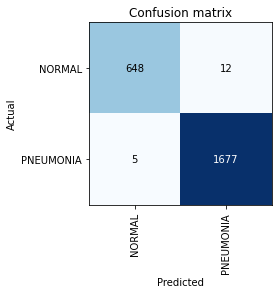

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Por ejemplo, ahora vemos que nuestro recuerdo está cerca del 100% y que **los falsos negativos solo ocurren el 0.01% del tiempo.**


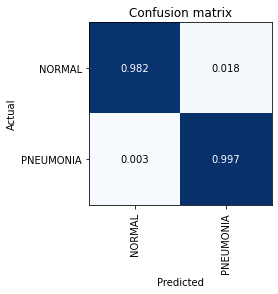

In [22]:
interp.plot_confusion_matrix(normalize=True, norm_dec=3)

Los resultados son muy buenos. Logramos reducir el número de falsos positivos.

Sin embargo, los falsos negativos aumentaron.

Sin embargo, mejoramos el modelo, que era nuestro objetivo.

Estas clasificaciones erróneas se muestran a continuación de forma explícita:

In [23]:
interp.most_confused(min_val=1)

# Shown is 'ACTUAL, PREDICTED, COUNT'

[('NORMAL', 'PNEUMONIA', 12), ('PNEUMONIA', 'NORMAL', 5)]

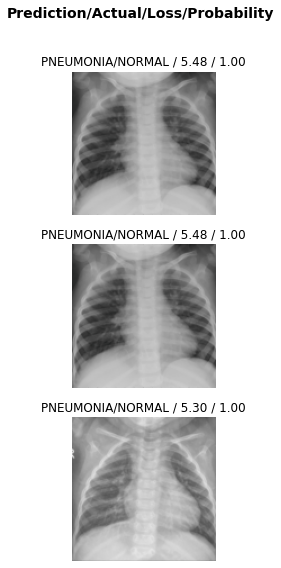

In [24]:
interp.plot_top_losses(3, nrows=3)

## ¿Cuántas épocas debemos entrenar?

Tu primer enfoque de entrenamiento debería ser simplemente elegir una serie de épocas que entrenarán en la cantidad de tiempo que está dispuesto a esperar.

Luego, observe los gráficos de pérdida y validación y, en particular, **las métricas**. Si ves que todavía están mejorando incluso en tus épocas finales, entonces sabes que no has entrenado por mucho tiempo.

Recuerda, no es solo que estamos buscando que la pérdida de validación empeore, sino también las métricas reales. Es importante darse cuenta de este factor y puede cambiar la forma en que se abordan los problemas de aprendizaje automático y aprendizaje profundo. Si sus métricas deseadas están mejorando, en el conjunto de validación o prueba, ese es el factor más importante.

La función de pérdida es algo que usamos para permitir que nuestro optimizador tenga algo que pueda diferenciar y optimizar; en realidad, no es lo que nos importa en la práctica.

## Descongelando el Modelo

Un modelo previamente entrenado, como el modelo ResNet que estamos usando aquí, se puede utilizar en datos distintos de los datos en los que se entrenó; esto es tranferencia de aprendizaje.

Debido a que el modelo se entrenó en algún otro conjunto de datos, podríamos mejorarlo eliminando efectivamente la capa lineal final del modelo, que está diseñada específicamente para clasificar las categorías en el conjunto de datos previo al entrenamiento original, y reemplazarlo con una capa específica para nuestro conjunto de datos.

Cuando llamamos al método fine_tune, FastAI hace dos cosas:

- Entrena las capas agregadas aleatoriamente para una época, con todas las demás capas congeladas
- Descongela todas las capas y las entrena todas para el número de épocas solicitadas

In [25]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.230342,0.116592,0.038856,0.961144,04:52
1,0.124700,0.072292,0.025192,0.974808,05:03
2,0.073858,0.057738,0.022630,0.977370,04:57


Ahora, descongelando el modelo completo podemos encontrar una nueva tasa de aprendizaje.

In [26]:
learn.unfreeze()

SuggestedLRs(valley=6.30957365501672e-05)

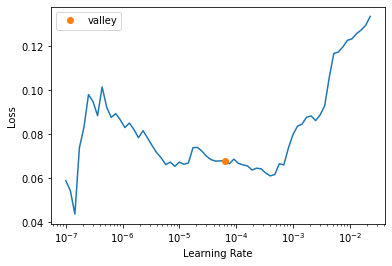

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(5, lr_max=3e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.062203,0.055760,0.019641,0.980359,04:58
1,0.060470,0.052484,0.019214,0.980786,04:57
2,0.058607,0.049859,0.019641,0.980359,04:55
3,0.057114,0.047386,0.016652,0.983348,05:00
4,0.052748,0.047609,0.016225,0.983775,04:55


El modelo no funcionó tan bien como los modelos anteriores.

Podemos intentar con otro modelo.

## Tasas de aprendizaje discriminativas

FastAI le permite pasar un objeto de segmento de Python en cualquier lugar donde se espere una tasa de aprendizaje. El primer valor pasado será la tasa de aprendizaje en la capa más temprana de la red neuronal, y el segundo valor será la tasa de aprendizaje en la capa final.

el rango seleccionado es basado en la gráfica anteriorimente usada.

Entrenaremos por un tiempo para ver cómo funciona el modelo. Cuando nuestras puntuaciones ya son tan altas, es difícil mejorar, por lo que no se espera mucha mejora.

In [29]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fit_one_cycle(3, 5e-3)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(5e-3,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.248619,0.126889,0.039710,0.960290,04:57
1,0.106757,0.060397,0.022203,0.977797,04:51
2,0.087701,0.054437,0.019641,0.980359,04:49


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.136971,1.054396,0.190863,0.809137,05:07
1,0.134829,0.244497,0.097780,0.902220,04:54
2,0.144130,0.169261,0.031170,0.968830,04:48
3,0.114926,0.160660,0.061059,0.938941,04:52
4,0.103416,0.552123,0.173783,0.826217,04:52
5,0.080661,0.049495,0.013664,0.986336,04:53
6,0.052920,0.039928,0.013237,0.986763,04:57
7,0.039713,0.035525,0.009821,0.990179,05:00


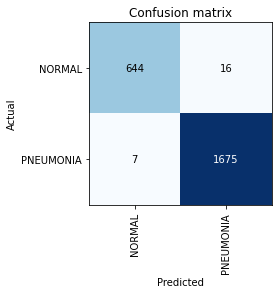

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

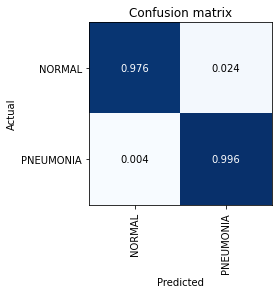

In [31]:
interp.plot_confusion_matrix(normalize=True, norm_dec=3)

Ciertamente no mejoramos nuestros resultados anteriores, pero la precisión del 99% aún no puede considerarse un resultado deficiente.

Probar con ResNet más grandes y tablas de comparación.